In [1]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.functional import binary_cross_entropy_with_logits
from torch_geometric.data import Data, Batch
import matplotlib.pyplot as plt
import logging as log
import os
import glob

# logger
log.basicConfig(level=log.INFO)
log.getLogger("pyGeoMatchImm").setLevel(log.INFO)
log.getLogger("MDAnalysis").setLevel(log.WARNING)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:

def load_structural_data(tcr3d_path: str,
                         af_score3_path: str,
                         af_score2_path: str,
                         id10x:list = []):
    map_cols = {
        'TCR_ID': 'id',
        'TRA_ref': 'TRA',
        'TRB_ref': 'TRB',
        'MHCseq_ref': 'MHCseq',
        'assigned_allele': 'mhc_allele',
        'peptide': 'epitope'
    }

    # Load Experimental Data
    tcr3d_data = pd.read_csv(tcr3d_path, index_col=0)
    tcr3d_data.drop(['TRA', 'TRB', 'MHCseq'], axis=1, inplace=True)
    tcr3d_data.rename(columns=map_cols, inplace=True)
    tcr3d_data.reset_index(drop=True, inplace=True)

    # Load AF score 3 Data
    af_score3_data = pd.read_csv(af_score3_path)
    af_score3_data.rename(columns=map_cols, inplace=True)
    af_score3_data.reset_index(drop=True, inplace=True)
    
    # Load AF score 2 Data
    af_score2_data = pd.read_csv(af_score2_path)
    af_score2_data.rename(columns=map_cols, inplace=True)
    af_score2_data.reset_index(drop=True, inplace=True)

    af_data = pd.concat([af_score3_data, af_score2_data], ignore_index=True)
    af_data = af_data[af_data['filepath_a'].notna() & af_data['filepath_b'].notna()]
    af_data.reset_index(drop=True, inplace=True)

    if len(id10x) > 0:
        af_data = af_data[~af_data['Reference'].isin(id10x)]

    print(f'Final AlphaFold training data size:{af_data.shape}')

    # remove overlapping epitopes
    tcr3d_data = tcr3d_data[~tcr3d_data['epitope'].isin(af_data['epitope'])]

    print(f'TCR3D training data size after removing overlapping epitopes: {tcr3d_data.shape}')

    train_data = pd.concat([tcr3d_data, af_data], ignore_index=True)
    train_data = train_data.dropna(subset=['filepath_a', 'filepath_b'], how='any')

    print(f'Total training data size: {train_data.shape}')

    select_columns = ['id', 'TRA', 'TRB', 'CDR1A', 'CDR2A', 'CDR3A', 'CDR1B', 'CDR2B', 'CDR3B', 'TRA_num', 'TRB_num', 'epitope', 'MHCseq', 'mhc_allele', 'filepath_a', 'filepath_b', 'label', 'source', 'Reference']
    train_data.drop_duplicates(subset=["TRA", "TRB", "epitope", "MHCseq"], inplace=True)
    train_data = train_data[select_columns].copy()

    return train_data

def sort_peptides(df: pd.DataFrame) -> pd.DataFrame:
    """ Sort dataframe by peptide frequency (ascending) """
    pep_counts = df['epitope'].value_counts()
    log.info(f"Peptide counts (ascending): {pep_counts}")
    pep_order = pep_counts.sort_values(ascending=True).index.tolist()
    log.info(f"Peptide order (ascending): {pep_order}")
    return pep_order, pep_counts.sort_values(ascending=True).to_frame()


#Paths
tcr3d_path = "../../data/02-processed/tcr3d_20251004_renamed.csv"
af_score3_path = "../../data/01-raw/AF_vdjdb_score3_20251212.csv"
af_score2_1217_path = "../../data/01-raw/AF_vdjdb_score2_wojust10x_20251217.csv"
af_score2_0105_path = "../../data/01-raw/AF_vdjdb_score2_wojust10x_20260105.csv"
id10x = ['34793243', '30418433', '35383307', '37872153', '32081129','30451992', '34811538']

log.info("Loading 12/17 dataset:")
df1217 = load_structural_data(tcr3d_path, af_score3_path, af_score2_1217_path)

log.info("Loading 01/05 dataset:")
df0105 = load_structural_data(tcr3d_path, af_score3_path, af_score2_0105_path)

diff_df = df0105[~df0105['id'].isin(df1217['id'])]
diff_df_wo10x = diff_df[~diff_df['Reference'].isin(id10x)]

add_peptides, peptides_df = sort_peptides(diff_df_wo10x)


INFO:root:Loading 12/17 dataset:
INFO:root:Loading 01/05 dataset:
INFO:root:Peptide counts (ascending): epitope
NLVPMVATV        150
SPRWYFYYL        129
TTDPSFLGRY       104
KTFPPTEPK         87
YLQPRTFLL         42
                ... 
RQWGPDPAAV         1
YQFGPDFPIA         1
KLVALVINAV         1
HSKKKCDEL          1
LPEPLPQGQLGAY      1
Name: count, Length: 99, dtype: int64
INFO:root:Peptide order (ascending): ['RMYSPVSIL', 'KIYSKHTPI', 'RARSVASQSI', 'LLFGYPVYV', 'SLLMWITQC', 'EPLPQGQLTAY', 'EENLLDFVRF', 'EEYLKAWTF', 'EEYLQAFTY', 'GLCTLVAML', 'ALWGPDPAAA', 'RFPLTFGWCF', 'SMLGIGIVPV', 'MMWDRGLGMM', 'SLYNTIATL', 'LPFDKPTIM', 'LPFEKSTVM', 'LPFERATIM', 'LRVMMLAPF', 'GQVMVVAPR', 'YLEPGPVTA', 'GPEPLPQGQLTAY', 'ALQIPFAMQM', 'RMYSPVSI', 'YPDKVFRSSV', 'FPQSAPHGVVF', 'KLVALVINAV', 'YQFGPDFPIA', 'RQWGPDPAAV', 'YLGGPDFPTI', 'MVWGPDPLYV', 'RQFGPDFPTI', 'TAFTIPSI', 'RQFGPDWIVA', 'AQWGPDPAAA', 'ILAKFLHWL', 'SLYNTVATL', 'SLFNTIAVL', 'VMAPRTLVL', 'GTSGSPIVNR', 'GTSGSPIINR', 'YLEPGPVTV', 'KRWIIMGLNK

Final AlphaFold training data size:(1473, 24)
TCR3D training data size after removing overlapping epitopes: (209, 18)
Total training data size: (1682, 24)
Final AlphaFold training data size:(2829, 24)
TCR3D training data size after removing overlapping epitopes: (104, 18)
Total training data size: (2933, 24)


In [3]:

# cumulative addition of peptides
train_data = df1217.copy()
#already_added_peps = ['RMYSPVSIL', 'KIYSKHTPI', 'RARSVASQSI', 'LLFGYPVYV', 'SLLMWITQC', 'EPLPQGQLTAY', 'EENLLDFVRF', 'EEYLKAWTF', 'EEYLQAFTY', 'GLCTLVAML', 'ALWGPDPAAA', 'RFPLTFGWCF', 'SMLGIGIVPV', 'MMWDRGLGMM']
already_added_peps = []
for i, add_pep in enumerate(add_peptides):

    if add_pep in already_added_peps:
        continue
    else:
        already_added_peps.append(add_pep)
        log.info(f"Adding peptide {i}/{len(add_peptides)}: {add_pep}")
        #log.info(f"Peptides added so far: {already_added_peps}\n")


    pep_df = diff_df_wo10x[diff_df_wo10x['epitope'].isin(already_added_peps)]
    train_data = pd.concat([train_data, pep_df], ignore_index=True)
    train_data.drop_duplicates(subset=["TRA", "TRB", "epitope", "MHCseq"], inplace=True)
    peptides_df.loc[add_pep, 'added_order'] = i
    peptides_df.loc[add_pep, 'size'] = train_data.shape[0]
    counts_pep_before = df1217['epitope'].value_counts().get(add_pep, 0)
    peptides_df.loc[add_pep, 'count_before'] = counts_pep_before

peptides_df.to_csv("added_peptides_cumulative.csv", index=True)

INFO:root:Adding peptide 0/99: RMYSPVSIL
INFO:root:Adding peptide 1/99: KIYSKHTPI
INFO:root:Adding peptide 2/99: RARSVASQSI
INFO:root:Adding peptide 3/99: LLFGYPVYV
INFO:root:Adding peptide 4/99: SLLMWITQC
INFO:root:Adding peptide 5/99: EPLPQGQLTAY
INFO:root:Adding peptide 6/99: EENLLDFVRF
INFO:root:Adding peptide 7/99: EEYLKAWTF
INFO:root:Adding peptide 8/99: EEYLQAFTY
INFO:root:Adding peptide 9/99: GLCTLVAML
INFO:root:Adding peptide 10/99: ALWGPDPAAA
INFO:root:Adding peptide 11/99: RFPLTFGWCF
INFO:root:Adding peptide 12/99: SMLGIGIVPV
INFO:root:Adding peptide 13/99: MMWDRGLGMM
INFO:root:Adding peptide 14/99: SLYNTIATL
INFO:root:Adding peptide 15/99: LPFDKPTIM
INFO:root:Adding peptide 16/99: LPFEKSTVM
INFO:root:Adding peptide 17/99: LPFERATIM
INFO:root:Adding peptide 18/99: LRVMMLAPF
INFO:root:Adding peptide 19/99: GQVMVVAPR
INFO:root:Adding peptide 20/99: YLEPGPVTA
INFO:root:Adding peptide 21/99: GPEPLPQGQLTAY
INFO:root:Adding peptide 22/99: ALQIPFAMQM
INFO:root:Adding peptide 23/99:

In [4]:
results_path = "/home/samuel.assis/MatchImm/MatchImmNet/developments/filling_0105data"

for row in peptides_df.itertuples():
    pep = row.Index
    size = row.size
    added_order = int(row.added_order)

    result_dir = glob.glob(os.path.join(results_path, f"{added_order}_model_{pep}*"))
    if len(result_dir) == 0:
        continue
    else:
        result_dir = result_dir[0]
    
    metrics_file = [f for f in os.listdir(result_dir) if f.endswith("_summary.csv")][0]
    metrics_df = pd.read_csv(os.path.join(result_dir, metrics_file), index_col=0)

    #f1 per line
    f1 = 2 * (metrics_df['ap'] * metrics_df['precision']) / (metrics_df['ap'] + metrics_df['precision'])
    f1_mean = f1.mean()
    f1_std = f1.std()
    auc_mean = metrics_df['auc'].mean()
    auc_std = metrics_df['auc'].std()

    auc01_mean = metrics_df['auc01'].mean()
    auc01_std = metrics_df['auc01'].std()
    
    peptides_df.loc[pep, 'f1_mean'] = f1_mean
    peptides_df.loc[pep, 'f1_std'] = f1_std
    peptides_df.loc[pep, 'auc_mean'] = auc_mean
    peptides_df.loc[pep, 'auc_std'] = auc_std
    peptides_df.loc[pep, 'auc01_mean'] = auc01_mean
    peptides_df.loc[pep, 'auc01_std'] = auc01_std

    peptides_df = peptides_df.round(2)
peptides_df.to_csv("added_peptides_cumulative_performance.csv", index=True)

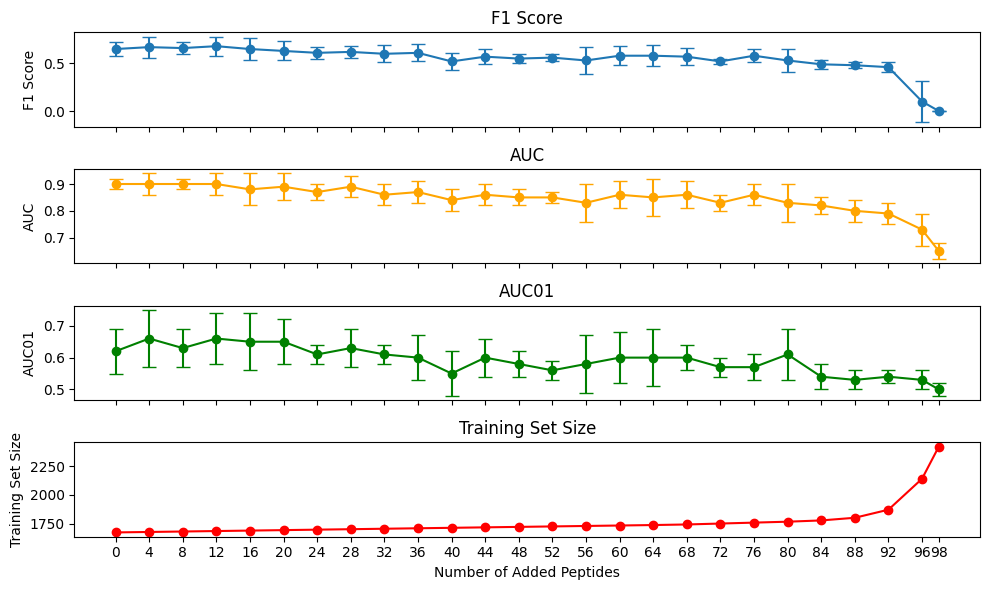

In [5]:
#keep multiple of 4 for plotting
peptides_df_filtered = peptides_df[(peptides_df['added_order'] % 4 == 0) | (peptides_df['added_order'] == 98)].copy()
#subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
axs[0].errorbar(peptides_df_filtered['added_order'], peptides_df_filtered['f1_mean'], yerr=peptides_df_filtered['f1_std'], fmt='-o', capsize=5)
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')   
axs[1].errorbar(peptides_df_filtered['added_order'], peptides_df_filtered['auc_mean'], yerr=peptides_df_filtered['auc_std'], fmt='-o', capsize=5, color='orange')
axs[1].set_title('AUC')
axs[1].set_ylabel('AUC')
axs[2].errorbar(peptides_df_filtered['added_order'], peptides_df_filtered['auc01_mean'], yerr=peptides_df_filtered['auc01_std'], fmt='-o', capsize=5, color='green')
axs[2].set_title('AUC01')
axs[2].set_ylabel('AUC01')
axs[3].plot(peptides_df_filtered['added_order'], peptides_df_filtered['size'], '-o', color='red') 
axs[3].set_title('Training Set Size')
axs[3].set_xlabel('Number of Added Peptides')
axs[3].set_ylabel('Training Set Size')

plt.xticks(peptides_df_filtered['added_order'])


plt.tight_layout()
plt.savefig("performance_vs_added_peptides.png")
plt.show()

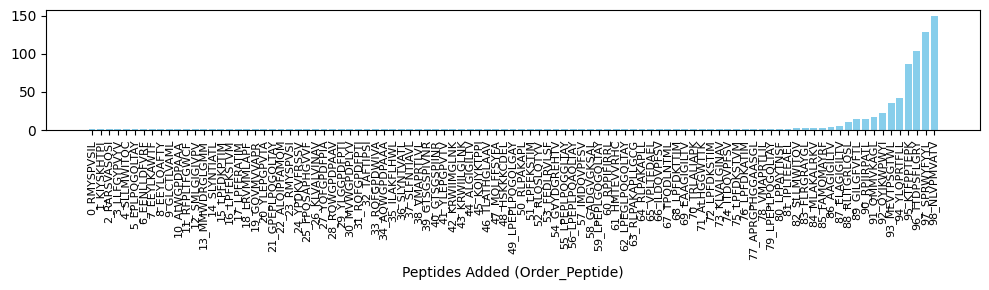

In [6]:
# barplot of peptides added

plt.figure(figsize=(10, 3))
x_axis = peptides_df['added_order'].astype(int).astype(str) + '_' + peptides_df.index

plt.bar(x_axis, peptides_df['count'], color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Peptides Added (Order_Peptide)')
plt.tight_layout()
plt.savefig("added_peptides_barplot.png")
plt.show()

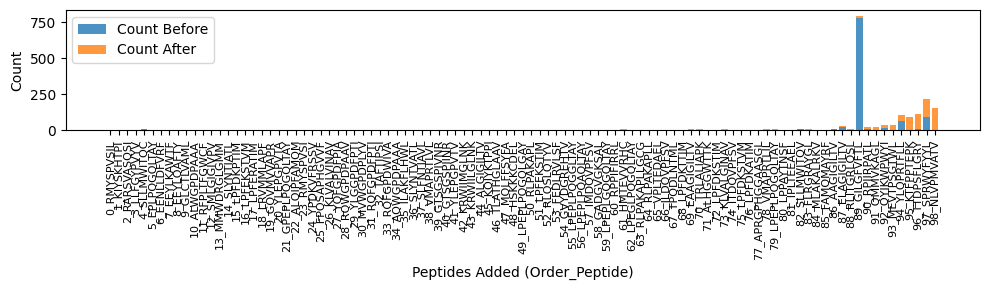

In [9]:
# Build x-axis labels
x_axis = (
    peptides_df['added_order'].astype(int).astype(str)
    + '_' +
    peptides_df.index.astype(str)
)

# Sort consistently (important)
df = peptides_df.loc[x_axis.index]

plt.figure(figsize=(10, 3))

plt.bar(
    x_axis,
    df['count_before'],
    label='Count Before',
    alpha=0.8
)

plt.bar(
    x_axis,
    df['count'],
    bottom=df['count_before'],
    label='Count After',
    alpha=0.8
)

plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Peptides Added (Order_Peptide)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig("peptide_counts_stacked.png", dpi=300)
plt.show()

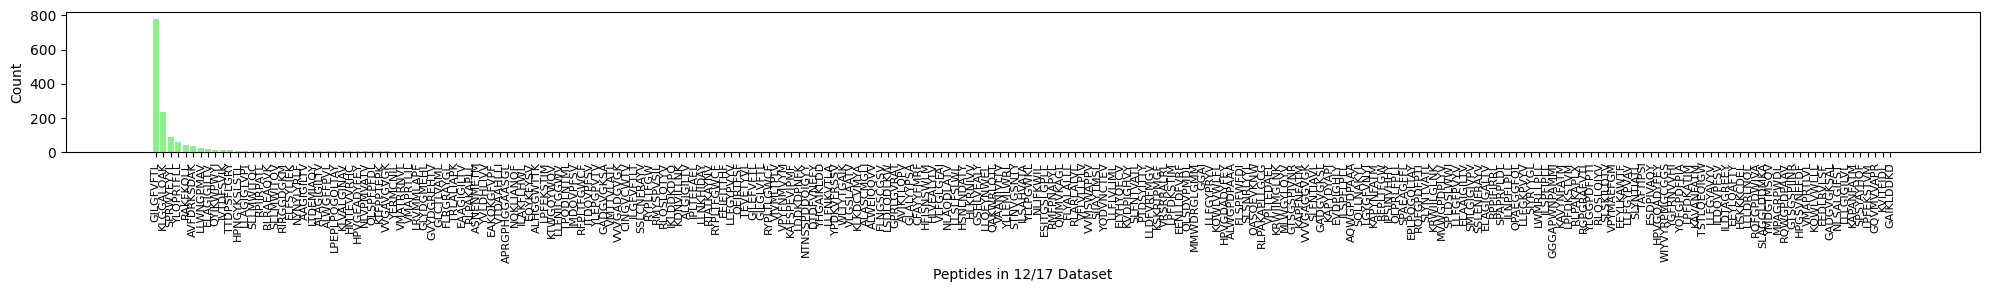

In [11]:
# barplot to count of peptides df1217
pep_counts_1217 = df1217['epitope'].value_counts()
plt.figure(figsize=(20, 3))
plt.bar(pep_counts_1217.index, pep_counts_1217.values, color='lightgreen')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Peptides in 12/17 Dataset')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("peptide_counts_1217.png", dpi=300)